In [1]:
from heidelberg_v02_more_metrics import leaky_integrate
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import pandas as pd

## Single neuron

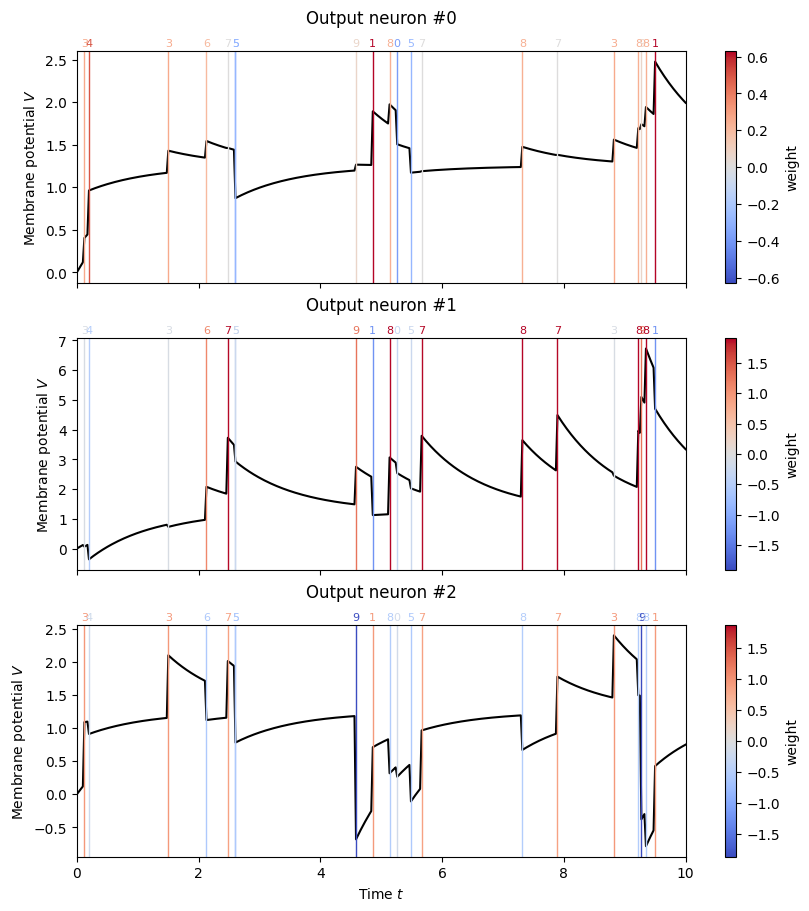

In [2]:
from functools import partial
from matplotlib import cm, colors, transforms

def create_args(N_t: int, N_sp: int, N_in: int, N_out: int, config: dict, seed=0):
    key = jax.random.PRNGKey(0)
    key1, key2, key3 = jax.random.split(key, 3)
    
    eval_times = jnp.linspace(0, config["T"], 400)

    # choose N_sp random times for the spikes and store whether the neuron spiked at that time
    spike_time_indices = jax.random.randint(
        key1, shape=(N_sp,), minval=0, maxval=len(eval_times)
    ).sort()
    spike_times = eval_times[spike_time_indices]
    spike_neurons = jax.random.randint(key2, shape=(N_sp,), minval=0, maxval=N_in)
    spikes = (spike_times, spike_neurons)

    input_spike_mask = jnp.full(N_sp, True)  # use all spikes as inputs

    weight_scale = 1
    weights = jax.random.normal(key3, shape=(N_out, N_in)) * weight_scale

    V_0 = jnp.zeros(N_out)

    return eval_times, spikes, weights, V_0, input_spike_mask, config


config = {
    "I0": 5 / 4,
    "tau": 1,
    "T": 10,
}


N_t = 400
N_sp = 20
N_out = 3
N_in = 10
args = eval_times, spikes, weights, _, _, _ = create_args(N_t, N_sp, N_in, N_out, config)

V_arr = leaky_integrate(*args)

fig, axs = plt.subplots(
    N_out, figsize=(8, 3 * N_out), squeeze=False, sharex=True, constrained_layout=True
)
axs = axs.flat

weight_cmap = plt.get_cmap("coolwarm")

for i_out, ax in enumerate(axs):
    ax.plot(eval_times, V_arr[i_out], color="black")
    ax.set_title(f"Output neuron #{i_out}", pad=20)

    max_abs_weight = jnp.abs(weights[i_out]).max().item()
    weight_norm = colors.Normalize(-max_abs_weight, max_abs_weight)

    for spike_time, spike_neuron in zip(*spikes):
        weight = weights[i_out, spike_neuron]
        color = weight_cmap(weight_norm(weight))

        ax.axvline(spike_time, color=color, lw=1)

        ax.text(
            spike_time,
            1.01,
            str(spike_neuron),
            ha="center",
            va="bottom",
            fontsize=8,
            color=color,
            transform=transforms.blended_transform_factory(ax.transData, ax.transAxes),
        )

    # Simulate again, but without intermediate time points
    # eval_times = np.concatenate([[0], spike_times, [config["T"]]])
    # spike_mask = np.ones(len(eval_times), dtype=bool)
    # spike_mask[0] = spike_mask[-1] = False  # first and last time point are not spikes

    # V_arr = leaky_integrate(eval_times, V_0=0, w=1, spike_mask=spike_mask, config=config)

    # plt.plot(eval_times, V_arr, linestyle="--", label="without intermediate times")

    ax.set_ylabel("Membrane potential $V$")
    plt.colorbar(cm.ScalarMappable(weight_norm, weight_cmap), ax=ax, label="weight")

axs[-1].set_xlabel("Time $t$")
axs[-1].set_xlim(0, config["T"])
# plt.legend()
plt.show()

## JIT testing

In [3]:
jax.config.update("jax_enable_compilation_cache", False)

In [4]:
%%timeit

leaky_integrate(*args);

2.92 ms ± 12.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Jit without config for single call.

In [5]:
%%timeit

@jax.jit
def jleaky_integrate(eval_times, spikes, weights, V_0, input_spike_mask):
    return leaky_integrate(eval_times, spikes, weights, V_0, input_spike_mask, config)

jleaky_integrate(*args[:-1]);

43 ms ± 391 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Jit without any args for single call.

In [6]:
%%timeit

@jax.jit
def jleaky_integrate():
    return leaky_integrate(*args)

jleaky_integrate()

34.5 ms ± 394 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Dependence on spike count.

In [10]:
import timeit

from tqdm import tqdm


def compile_and_call_leaky_integrate(n_calls, args):
    jleaky_integrate = jax.jit(partial(leaky_integrate, *args))
    
    for _ in range(n_calls):
        jleaky_integrate()

data = pd.DataFrame(columns=["N_sp", "time", "time_jit_1", "time_jit_2", "time_jit_10"])
n_repeat = 10

for i, N_out in enumerate(tqdm(range(1, 20))):
    args = create_args(N_t, N_sp, N_in, N_out, config)
    time = timeit.timeit(lambda: leaky_integrate(*args), number=n_repeat)
    time_jit_1 = timeit.timeit(lambda: compile_and_call_leaky_integrate(1, args), number=n_repeat)
    time_jit_2 = timeit.timeit(lambda: compile_and_call_leaky_integrate(2, args), number=n_repeat)
    time_jit_10 = timeit.timeit(lambda: compile_and_call_leaky_integrate(10, args), number=n_repeat)

    data.loc[i] = [N_out, time, time_jit_1, time_jit_2, time_jit_10]

data

100%|██████████| 19/19 [00:20<00:00,  1.07s/it]


,N_sp,time,time_jit_1,time_jit_2,time_jit_10
0,1.0,0.029897,0.257415,0.251411,0.253897
1,2.0,0.029220,0.330349,0.334031,0.334796
2,3.0,0.029145,0.331778,0.334635,0.345056
3,4.0,0.029407,0.332047,0.329299,0.345923
4,5.0,0.029378,0.319355,0.325219,0.324651
5,6.0,0.029518,0.328642,0.328242,0.315557
6,7.0,0.029776,0.314870,0.323218,0.325087
7,8.0,0.029537,0.323774,0.317586,0.323393
8,9.0,0.031690,0.322218,0.320273,0.327250
9,10.0,0.030022,0.322365,0.317430,0.323103


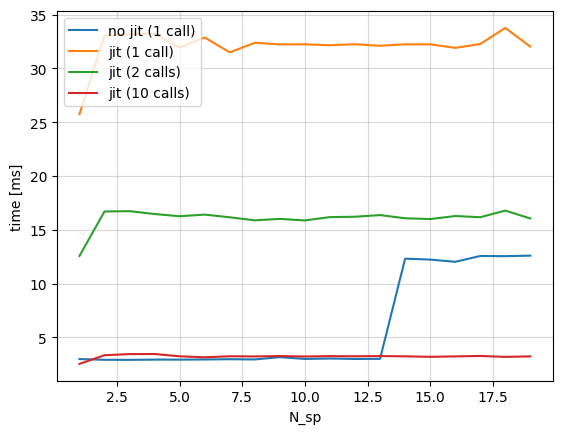

In [11]:
plt.plot(data["N_sp"], data["time"] / n_repeat * 1000, label="no jit (1 call)")
plt.plot(data["N_sp"], data["time_jit_1"] / n_repeat * 1000, label="jit (1 call)")
plt.plot(data["N_sp"], data["time_jit_2"] / 2 / n_repeat * 1000, label="jit (2 calls)")
plt.plot(data["N_sp"], data["time_jit_10"] / 10 / n_repeat * 1000, label="jit (10 calls)")

plt.xlabel("N_sp")
plt.ylabel("time [ms]")
plt.grid(alpha=0.5)
plt.legend()
plt.show()

-> JIT not effective when function is only called once